# Coursework IDA

## Task 1

## 1.1. 
Implement and train a method for automatically classifying texts in the FiQA sentiment analysis
dataset as positive, neutral or negative. Refer to the labs, lecture materials and textbook to identify
a suitable method. In your report:
• Briefly explain how your chosen method works and its main strengths and limitations;
• Describe the preprocessing steps and the features you use to represent each text instance;
• Explain why you chose those features and preprocessing steps and hypothesise how they
will affect your results;
• Briefly describe your software implementation.
(10 marks)



In [22]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset
import pandas as pd
import numpy as np
import json

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

# pre trained analyser for comparison
from nltk.sentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt

# for negation
import re


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\loz\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [23]:
train_files = [
    'data_cache/FiQA_ABSA_task1/task1_headline_ABSA_train.json',
    'data_cache/FiQA_ABSA_task1/task1_post_ABSA_train.json'
]

In [24]:


def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    # iterate through each tweet file
    for file in json_files:
        # open file in read mode, with method closes file after getting data stream
        with open(file, 'r', encoding = 'utf8') as handle:
            # load file object and convert into json object
            dataf = json.load(handle)
        
        
        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        # print(len(dataf_text))
        train_text.extend(dataf_text)

        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        # print(len(dataf_labels))
        train_labels.extend(dataf_labels)

    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.25:
            labels.append(0)
        elif score > 0.32:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 283
Number of neutral labels: 359
Number of positive labels: 469


In [25]:
#print(all_text_negated[0:50])

In [26]:
print(all_labels[0])

0


In [27]:
type(load_fiqa_sa_from_json(train_files))

tuple

In [28]:
print(len(load_fiqa_sa_from_json(train_files)[0]))

1111


In [29]:

# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
train_documents, val_documents, train_labels, val_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.15, 
    stratify=train_labels  # make sure the same proportion of labels is in the test set and training set
)

print(f'Number of training instances = {len(train_documents)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_documents)}')


Number of training instances = 754
Number of validation instances = 134
Number of test instances = 223


In [30]:
print(f'What does one instance look like from the training set? \n\n{train_documents[233]}')
print(f'...and here is its corresponding label \n\n{train_labels[233]}')

What does one instance look like from the training set? 

$RUSS Don't catch falling knives, but I think an entry is coming soon on this
...and here is its corresponding label 

1


In [35]:


# CountVectorizer can do its own tokenization, but for consistency we want to
# carry on using WordNetTokenizer. We write a small wrapper class to enable this:
class Tokenizer(object):
    def __call__(self, tweets):
        return word_tokenize(tweets)

    
# create stopwords function from nltk
stop_words = set(stopwords.words('english'))
vectorizer = CountVectorizer(tokenizer=Tokenizer())  # construct the vectorizer
# with stop word removal
#vectorizer = CountVectorizer(tokenizer=Tokenizer(), stop_words=stop_words)  # construct the vectorizer

vectorizer.fit(train_documents)  # Learn the vocabulary
X_train = vectorizer.transform(train_documents)  # extract training set bags of words
X_val = vectorizer.transform(val_documents)  # extract test set bags of words
X_test = vectorizer.transform(test_documents)  # extract test set bags of words

In [36]:
# print(nltk.data.path)

In [37]:
# see count vector from training set
counts = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())

In [38]:
X_train

<754x3338 sparse matrix of type '<class 'numpy.int64'>'
	with 10621 stored elements in Compressed Sparse Row format>

In [39]:
counts.columns


Index(['!', '#', '$', '%', '&', ''', '''', ''15', ''best', ''breached',
       ...
       'â£180m', 'â£250m', 'â£3.5bn', 'â£30m', 'â£347', 'â£90m', 'â€', '’',
       '“', '”'],
      dtype='object', length=3338)

## Naive Bayes Classifier

In [40]:
# WRITE YOUR CODE HERE
classifier = MultinomialNB()
classifier.fit(X_train, train_labels)

MultinomialNB()

In [41]:
y_val_pred = classifier.predict(X_val)

In [42]:
cm = metrics.confusion_matrix(val_labels, y_val_pred)


In [43]:
# Define class labels
classes = ['0', '1', '2']


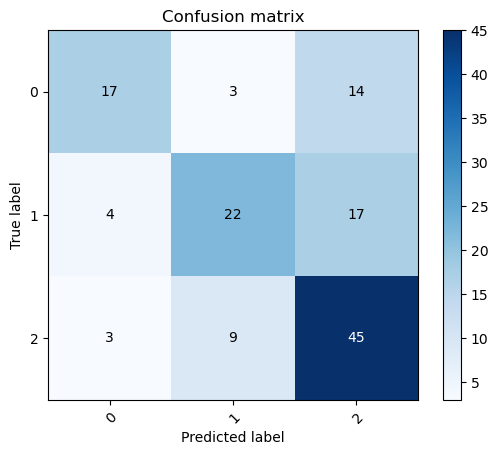

In [44]:
# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Add counts to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Show plot
plt.show()

In [45]:
# WRITE YOUR CODE HERE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(val_labels, y_val_pred))

Accuracy = 0.6268656716417911
Precision (macro average) = 0.6491658066735466
Recall (macro average) = 0.6003671970624235
F1 score (macro average) = 0.6114423991012012
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        34
           1       0.65      0.51      0.57        43
           2       0.59      0.79      0.68        57

    accuracy                           0.63       134
   macro avg       0.65      0.60      0.61       134
weighted avg       0.64      0.63      0.62       134



In [46]:
vocabulary = vectorizer.vocabulary_

### CHANGE THE NAME OF THE CLASSIFIER VARIABLE BELOW TO USE YOUR TRAINED CLASSIFIER
feat_likelihoods = np.exp(classifier.feature_log_prob_)  # Use exponential to convert the logs back to probabilities
###

# WRITE YOUR CODE HERE
print(feat_likelihoods[:, vocabulary['a']])
print(feat_likelihoods[:, vocabulary['it']])

[0.00447785 0.00534065 0.00737963]
[0.00287862 0.0034642  0.00217759]


# Logistic Regression Classifier



In [47]:


classifier = LogisticRegression()
classifier.fit(X_train, train_labels)

LogisticRegression()

In [48]:
y_val_pred = classifier.predict(X_val)

In [49]:
cm = metrics.confusion_matrix(val_labels, y_val_pred)


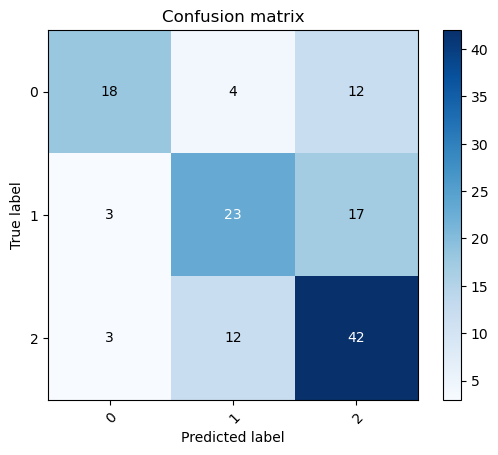

In [50]:

# Define class labels
classes = ['0', '1', '2']

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Add counts to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Show plot
plt.show()

## 1.2. Evaluate Method

Evaluate your method, then interpret and discuss your results. Include the following points:
• Define your performance metrics and state their limitations;
• Describe the testing procedure (e.g., how you used each split of the dataset);
• Show your results using suitable plots or tables;
• How could you improve the method or experimental process? Consider the errors that your
method makes.  
(9 marks)


In [51]:
# WRITE YOUR CODE HERE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(val_labels, y_val_pred))

Accuracy = 0.6194029850746269
Precision (macro average) = 0.6437642951727459
Recall (macro average) = 0.6003791969664243
F1 score (macro average) = 0.6126384216428371
              precision    recall  f1-score   support

           0       0.75      0.53      0.62        34
           1       0.59      0.53      0.56        43
           2       0.59      0.74      0.66        57

    accuracy                           0.62       134
   macro avg       0.64      0.60      0.61       134
weighted avg       0.63      0.62      0.62       134



## With Data Processing

In [52]:
def add_negation(sentence):
    # define regex pattern to match words after "not", "n't", or "never"
    pattern = r"(?:(?:(?:not)|(?:n't)|(?:never))\s+)(\w+)"
    
    # use regex to find and replace words with negation prefix
    result = re.sub(pattern, r" not_\1", sentence)
    
    return result

In [53]:
# apply add_negation to each tweet in the array using a list comprehension
all_text_negated = np.array([add_negation(text) for text in all_text])


In [54]:
# convert all tweets to lower case
all_text_negated = np.char.lower(all_text_negated)

In [55]:

# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text_negated, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
train_documents, val_documents, train_labels, val_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.15, 
    stratify=train_labels  # make sure the same proportion of labels is in the test set and training set
)

print(f'Number of training instances = {len(train_documents)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_documents)}')


Number of training instances = 754
Number of validation instances = 134
Number of test instances = 223


In [56]:
print(f'What does one instance look like from the training set? \n\n{train_documents[233]}')
print(f'...and here is its corresponding label \n\n{train_labels[233]}')

What does one instance look like from the training set? 

asahi could be about to snap up more of sabmiller's beers ahead of ab inbev sale
...and here is its corresponding label 

1


In [57]:


# CountVectorizer can do its own tokenization, but for consistency we want to
# carry on using WordNetTokenizer. We write a small wrapper class to enable this:
class Tokenizer(object):
    def __call__(self, tweets):
        return word_tokenize(tweets)

    
# create stopwords function from nltk
stop_words = set(stopwords.words('english'))
#vectorizer = CountVectorizer(tokenizer=Tokenizer())  # construct the vectorizer

# with stop word removal
vectorizer = CountVectorizer(tokenizer=Tokenizer(), stop_words=stop_words)  # construct the vectorizer

vectorizer.fit(train_documents)  # Learn the vocabulary
X_train = vectorizer.transform(train_documents)  # extract training set bags of words
X_val = vectorizer.transform(val_documents)  # extract test set bags of words
X_test = vectorizer.transform(test_documents)  # extract test set bags of words

C:\Users\loz\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\loz\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [58]:
# see count vector from training set
counts = pd.DataFrame(X_train.toarray(), columns = vectorizer.get_feature_names_out())

In [59]:
X_train

<754x3155 sparse matrix of type '<class 'numpy.int64'>'
	with 8276 stored elements in Compressed Sparse Row format>

In [60]:
counts.columns


Index(['!', '#', '$', '%', '&', ''', '''', ''15', ''best', ''challenging',
       ...
       'â£22', 'â£250m', 'â£3.5bn', 'â£30m', 'â£347', 'â€', '’', '“', '”',
       '📈'],
      dtype='object', length=3155)

## Naive Bayes Classifier

In [61]:
# WRITE YOUR CODE HERE
classifier = MultinomialNB()
classifier.fit(X_train, train_labels)

MultinomialNB()

In [62]:
y_val_pred = classifier.predict(X_val)

In [63]:
cm = metrics.confusion_matrix(val_labels, y_val_pred)


In [64]:
# Define class labels
classes = ['0', '1', '2']


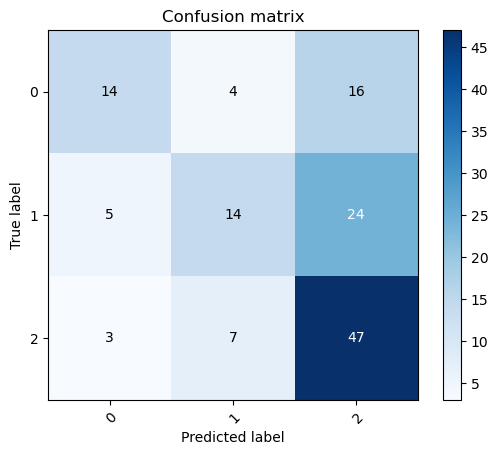

In [65]:
# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Add counts to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Show plot
plt.show()

In [66]:
# WRITE YOUR CODE HERE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(val_labels, y_val_pred))

Accuracy = 0.5597014925373134
Precision (macro average) = 0.5788645071403692
Recall (macro average) = 0.5206358349133207
F1 score (macro average) = 0.5215141612200437
              precision    recall  f1-score   support

           0       0.64      0.41      0.50        34
           1       0.56      0.33      0.41        43
           2       0.54      0.82      0.65        57

    accuracy                           0.56       134
   macro avg       0.58      0.52      0.52       134
weighted avg       0.57      0.56      0.54       134



In [67]:
vocabulary = vectorizer.vocabulary_

### CHANGE THE NAME OF THE CLASSIFIER VARIABLE BELOW TO USE YOUR TRAINED CLASSIFIER
feat_likelihoods = np.exp(classifier.feature_log_prob_)  # Use exponential to convert the logs back to probabilities
###

# WRITE YOUR CODE HERE
#print(feat_likelihoods[:, vocabulary['a']])
#print(feat_likelihoods[:, vocabulary['it']])

# Logistic Regression Classifier



In [68]:


classifier = LogisticRegression()
classifier.fit(X_train, train_labels)

LogisticRegression()

In [69]:
y_val_pred = classifier.predict(X_val)

In [70]:
cm = metrics.confusion_matrix(val_labels, y_val_pred)


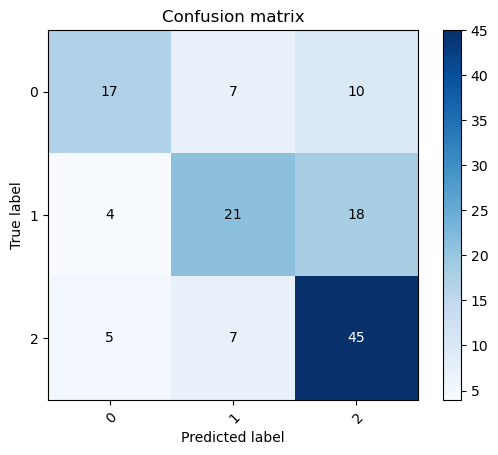

In [71]:

# Define class labels
classes = ['0', '1', '2']

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Add counts to each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Show plot
plt.show()

## 1.2. Evaluate Method

Evaluate your method, then interpret and discuss your results. Include the following points:
• Define your performance metrics and state their limitations;
• Describe the testing procedure (e.g., how you used each split of the dataset);
• Show your results using suitable plots or tables;
• How could you improve the method or experimental process? Consider the errors that your
method makes.  
(9 marks)


In [72]:
# WRITE YOUR CODE HERE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

acc = accuracy_score(val_labels, y_val_pred)
print(f'Accuracy = {acc}')

prec = precision_score(val_labels, y_val_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(val_labels, y_val_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(val_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(val_labels, y_val_pred))

Accuracy = 0.6194029850746269
Precision (macro average) = 0.6234281700035125
Recall (macro average) = 0.5926152590779273
F1 score (macro average) = 0.5991452991452991
              precision    recall  f1-score   support

           0       0.65      0.50      0.57        34
           1       0.60      0.49      0.54        43
           2       0.62      0.79      0.69        57

    accuracy                           0.62       134
   macro avg       0.62      0.59      0.60       134
weighted avg       0.62      0.62      0.61       134



# 1.3 Common Themes & Topics

1.3. Can you identify common themes or topics associated with negative sentiment or positive
sentiment in this dataset?
• Explain the method you use to identify themes or topics;
• Show your results (e.g., by listing or visualising example topics or themes);
• Interpret the results and summarise the limitations of your approach.
(12 marks) 

In [73]:
n_feats_to_show = 10

# Flip the index so that values are keys and keys are values:
keys = vectorizer.vocabulary_.values()
values = vectorizer.vocabulary_.keys()
vocab_inverted = dict(zip(keys, values))

for c, weights_c in enumerate(classifier.coef_):
    print(f'\nWeights for class {c}:\n')
    strongest_idxs = np.argsort(weights_c)[-n_feats_to_show:]

    for idx in strongest_idxs:
        print(f'{vocab_inverted[idx]} with weight {weights_c[idx]}')


Weights for class 0:

loss with weight 0.5946282189359996
lags with weight 0.6116964899182706
sbux with weight 0.6197941004763478
.. with weight 0.6293048989719633
falls with weight 0.6613785704159454
downside with weight 0.7562677448311711
lower with weight 0.8088473812079408
fall with weight 0.8726275141380198
bearish with weight 0.9989084045382505
short with weight 1.5817460860513832

Weights for class 1:

vxx with weight 0.521241445125847
closed with weight 0.5335047181318096
today with weight 0.5554813438939976
yhoo with weight 0.5872646440141072
bid with weight 0.6053148815238343
may with weight 0.6061858550992847
volatility with weight 0.6084711341851008
cnp with weight 0.6297787282427
action with weight 0.6373631661976468
ceo with weight 0.8334546764554256

Weights for class 2:

first with weight 0.6613857040649032
highs with weight 0.6833492643669505
higher with weight 0.7463070688196857
calls with weight 0.7551683289124187
hod with weight 0.7587107524211084
rise with weight 

### Topics

In [80]:
pos_index = all_labels == 2  # compare predictions to gold labels
neg_index = all_labels == 0  # compare predictions to gold labels
# get the text of tweets where the classifier made an error:
pos_tweets = np.array(all_text)[pos_index]
neg_tweets = np.array(all_text)[neg_index]

In [81]:
#type(pos_tweets)
print(pos_tweets[0])
print(neg_tweets[0])

Primark racks up a happy Christmas after strong sales
Royal Mail chairman Donald Brydon set to step down


In [82]:
processed_pos = []
processed_neg = []

In [83]:
from nltk.stem import WordNetLemmatizer 
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS # find stopwords

np.random.seed(400)  # We fix the random seed to ensure we get consistent results when we repeat the lab.

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in simple_preprocess(text) :  # Tokenize, remove very short and very long words, convert to lower case, remove words containing non-letter characters
        if token not in STOPWORDS:
            result.append(WordNetLemmatizer().lemmatize(token, 'v'))
            
    return result

# Create lists of preprocessed documents
for tweet in pos_tweets:
    processed_pos.append(preprocess(tweet))
    
for tweet in neg_tweets:
    processed_neg.append(preprocess(tweet))

In [84]:
# nltk.download('wordnet')

In [85]:
print(processed_pos[0])
print(processed_neg[0])

['primark', 'rack', 'happy', 'christmas', 'strong', 'sales']
['royal', 'mail', 'chairman', 'donald', 'brydon', 'set', 'step']


In [86]:
from gensim.corpora import Dictionary

dictionary_pos = Dictionary(processed_pos) # construct word<->id mappings - it does it in alphabetical order
print(dictionary_pos)

pos_bow_corpus = [dictionary_pos.doc2bow(tweet) for tweet in processed_pos]

dictionary_neg = Dictionary(processed_neg) # construct word<->id mappings - it does it in alphabetical order
print(dictionary_neg)

neg_bow_corpus = [dictionary_neg.doc2bow(tweet) for tweet in processed_neg]

Dictionary(1633 unique tokens: ['christmas', 'happy', 'primark', 'rack', 'sales']...)
Dictionary(1155 unique tokens: ['brydon', 'chairman', 'donald', 'mail', 'royal']...)


In [87]:
len(pos_bow_corpus)

469

In [88]:
len(neg_bow_corpus)

283

In [89]:
from gensim.models import LdaModel

lda_pos_model =  LdaModel(pos_bow_corpus, 
                      num_topics=10, 
                      id2word=dictionary_pos,                                    
                      passes=10,
                    ) 

lda_neg_model =  LdaModel(neg_bow_corpus, 
                      num_topics=10, 
                      id2word=dictionary_neg,                                    
                      passes=10,
                    ) 

In [90]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_pos_model.print_topics(-1):
    print("Pos Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")
    
for idx, topic in lda_neg_model.print_topics(-1):
    print("Neg Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Pos Topic: 0 
Words: 0.016*"buy" + 0.015*"https" + 0.012*"aapl" + 0.012*"look" + 0.012*"stks" + 0.012*"http" + 0.010*"good" + 0.008*"high" + 0.008*"dividend" + 0.008*"call"


Pos Topic: 1 
Words: 0.015*"price" + 0.015*"share" + 0.014*"day" + 0.010*"higher" + 0.010*"growth" + 0.009*"earn" + 0.008*"climb" + 0.008*"end" + 0.008*"run" + 0.008*"dividend"


Pos Topic: 2 
Words: 0.022*"https" + 0.015*"profit" + 0.014*"buy" + 0.013*"astrazeneca" + 0.011*"look" + 0.011*"tsla" + 0.009*"rise" + 0.008*"break" + 0.008*"continue" + 0.008*"sales"


Pos Topic: 3 
Words: 0.039*"long" + 0.037*"http" + 0.037*"stks" + 0.013*"https" + 0.011*"aapl" + 0.009*"market" + 0.009*"sales" + 0.008*"position" + 0.008*"go" + 0.008*"amzn"


Pos Topic: 4 
Words: 0.011*"higher" + 0.011*"astrazeneca" + 0.011*"https" + 0.010*"ftse" + 0.008*"approval" + 0.008*"support" + 0.006*"tesco" + 0.006*"billion" + 0.006*"steady" + 0.006*"buy"


Pos Topic: 5 
Words: 0.018*"stock" + 0.010*"new" + 0.010*"resistance" + 0.008*"watch" + 0.

### Individual Topic Distribution

In [91]:
test_document_idx = 10
unseen_document = pos_tweets[test_document_idx]
print(unseen_document)

#print(f' This document is from newsgroup {newsgroups_test.target_names[newsgroups_test.target[test_document_idx]]}')

# Data preprocessing step for the unseen document - It is the same preprocessing we have performed for the training data
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for idx, count in bow_vector:
    print(f'{dictionary[idx]}: {count}')

ARM Royalties Accelerate as Smartphone Market Regains Strength


NameError: name 'dictionary' is not defined

In [92]:
topic_distribution = lda_model[bow_vector]

for index, probability in sorted(topic_distribution, key=lambda tup: -1*tup[1]):
    print("Index: {}\nProbability: {}\t Topic: {}".format(index, probability, lda_model.print_topic(index, 5)))

NameError: name 'lda_model' is not defined

In [93]:
# make list of tuples ready for model training

train_set = list(zip(list_a, list_b))

NameError: name 'list_a' is not defined

## Task 2: Named Entity Recognition (max. 19%)  

In scientific research, information extraction can help researchers to discover relevant findings from
across a wide body of literature. As a first step, your task is to build a tool for named entity
recognition in scientific journal article abstracts. We will be working with the BioNLP 2004 dataset of
abstracts from MEDLINE, a database containing journal articles from fields including medicine and
pharmacy. The data was collected by searching for the terms ‘human’, ‘blood cells’ and
‘transcription factors’, and then annotated with five entity types: DNA, protein, cell type, cell line,
RNA. 

More information can be found in the paper: https://aclanthology.org/W04-1213.pdf .
We provide a cache of the data and code for loading the data in ‘data_loader_demo’ in our Github
repository, https://github.com/uob-TextAnalytics/intro-labs-public. This script downloaded the data
from HuggingFace, where you can also find more information about the dataset:
https://huggingface.co/datasets/tner/bionlp2004 .


The data is presented in this paper:
Nigel Collier, Tomoko Ohta, Yoshimasa Tsuruoka, Yuka Tateisi, and Jin-Dong Kim. 2004. Introduction
to the Bio-entity Recognition Task at JNLPBA. In Proceedings of the International Joint Workshop on
Natural Language Processing in Biomedicine and its Applications (NLPBA/BioNLP), pages 73–78,
Geneva, Switzerland. COLING.